In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np

from library.evaluation import ConfusionMatrix

random.seed(37)

unique_name = "DistilBERT_NLI_Mean"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr1_DistilBERT_NLI_Mean_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(5802, 768)

In [3]:
phemernr = pd.read_csv("../../data/processed/phemernr1_dataset_with_tvt.csv", lineterminator="\n")
phemernr.head()

,tweet_text,topic,label,tvt
0,BOMBSHELL: #Ferguson chief says the police off...,ferguson,rumours,test
1,It appears that #Ferguson PD are trying to ass...,ferguson,rumours,training
2,"All weekend ppl will be talking about the ""rob...",ferguson,rumours,test
3,Why would the officer tell #MikeBrown to get o...,ferguson,rumours,test
4,Michael Brown is the 17 yr old boy who was sho...,ferguson,rumours,training


In [4]:
labels = []
for i, p2 in phemernr.iterrows():
    if p2['label'] == 'rumours':
        labels.append([0])
    elif p2['label'] == 'non-rumours':
        labels.append([1])
    else:
        labels.append(None)
labels[:10]

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [5]:
train_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'training'])
val_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'validation'])
test_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'test'])

train_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'training'])
val_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'validation'])
test_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'test'])

In [6]:
label_tag = ['rumours', 'non-rumours']
label_tag

['rumours', 'non-rumours']

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

print("Class 0 : ", len([i for i in test_labels if i == 0]))
print("Class 1 : ", len([i for i in test_labels if i == 1]))

(3498, 768)
(1150, 768)
(1154, 768)
(3498, 1)
(1150, 1)
(1154, 1)
Class 0 :  381
Class 1 :  773


In [8]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(val_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([1175, 2323]))
(array([0, 1]), array([416, 734]))
(array([0, 1]), array([381, 773]))


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)
        self.final = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.final(out)
        return out


def ResNet10(n_input=768, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input)

    
def ResNet18(n_input=768, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input)


def ResNet34(n_input=768, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input)


def ResNet50(n_input=768, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input)


def ResNet101(n_input=768, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input)


def ResNet152(n_input=768, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)
        self.final = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.final(out)
        return out


def CNNResNet10():
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1])

    
def CNNResNet18():
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2])


def CNNResNet34():
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3])


def CNNResNet50():
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3])


def CNNResNet101():
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3])


def CNNResNet152():
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3])

In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
#                 for i, output in enumerate(outputs.tolist()):
#                     if targets[i,0].tolist() == round(output[0]):
#                         correct += 1

#             train_acc = round(100*correct/total, 4)
#             train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                
                if self.model_type == 'mlp':
                    outputs = self.model(inputs)
                else:
                    outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                
                loss = self.criterion(outputs, targets)
                try:
                    outputs = self.model(inputs.unsqueeze(1))
                except Exception:
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)
                test_loss += loss.item()
                
                if self.model_type == 'mlp':
                    preds = self.predict(test_x)
                else:
                    preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                conf_mat = ConfusionMatrix(
                    labels=test_y,
                    predictions=[p[0] for p in preds.cpu().numpy()],
                    binary=True
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.Tensor(input_x))

Multiclass Classification Phemernr1_ResNet10_MLP_DistilBERT_NLI_Mean
Using cuda
Saving after new best accuracy : 36.174
Saving after new best accuracy : 36.783
Saving after new best accuracy : 48.435
Saving after new best accuracy : 58.261
Saving after new best accuracy : 67.13
Saving after new best accuracy : 67.739
Saving after new best accuracy : 70.696
Saving after new best accuracy : 73.565
Saving after new best accuracy : 74.348
Saving after new best accuracy : 75.739
Saving after new best accuracy : 76.0
Saving after new best accuracy : 76.087
Saving after new best accuracy : 78.696
-- Epoch 50, Train Loss : 0.36812038347125053, Test Loss : 0.5909073948860168
-- Epoch 100, Train Loss : 0.14296713704243302, Test Loss : 0.6315289735794067
-- Epoch 150, Train Loss : 0.08506668731570244, Test Loss : 0.6647590398788452
-- Epoch 200, Train Loss : 0.057551456382498145, Test Loss : 0.7050941586494446
Saving after new best accuracy : 78.87
-- Epoch 250, Train Loss : 0.0396414203569293, T

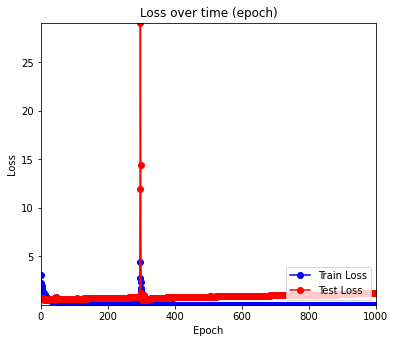


---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 608
False Positive : 114
False Negative : 126
True Negative : 302

Class positive Evaluation
- Precision : 84.211 %
- Recall : 82.834 %
- F1 : 0.83516

Class negative Evaluation
- Precision : 70.561 %
- Recall : 72.596 %
- F1 : 0.71564

Combined Evaluation
- Accuracy : 79.13 %
- Precision : 77.386 %
- Recall : 77.715 %
- F1 : 0.7755
- Average Confidence : 64.38 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet10_MLP_DistilBERT_NLI_Mean, 79.13, 77.386, 77.715, 0.7755, 84.211, 82.834, 0.83516, 70.561, 72.596, 0.71564, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 615
False Positive : 106
False Negative : 158
True Negative : 275

Class positive Evaluation
- Precision : 85.298 %
- Recall : 79.56 %
- F1 : 0.82329

Class negative Evaluation
- Precision : 63.51 %
- Recall : 72.178 %
- F1 : 0.67568

Combined Evaluation
- Accuracy 

In [12]:
model_name = f"Phemernr1_ResNet10_MLP_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(ResNet10(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16) #, device="cpu")
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

Multiclass Classification Phemernr1_ResNet18_MLP_DistilBERT_NLI_Mean
Using cuda
Saving after new best accuracy : 59.826
Saving after new best accuracy : 66.696
Saving after new best accuracy : 68.261
Saving after new best accuracy : 70.087
Saving after new best accuracy : 71.826
Saving after new best accuracy : 74.348
Saving after new best accuracy : 75.652
Saving after new best accuracy : 76.0
Saving after new best accuracy : 76.087
Saving after new best accuracy : 76.435
Saving after new best accuracy : 76.609
Saving after new best accuracy : 76.696
Saving after new best accuracy : 76.87
Saving after new best accuracy : 77.13
-- Epoch 50, Train Loss : 0.11866685096174479, Test Loss : 0.589926540851593
Saving after new best accuracy : 77.478
-- Epoch 100, Train Loss : 0.056492417585104704, Test Loss : 0.6554558873176575
Saving after new best accuracy : 77.652
Saving after new best accuracy : 78.348
Saving after new best accuracy : 78.957
-- Epoch 150, Train Loss : 0.05063247587531805,

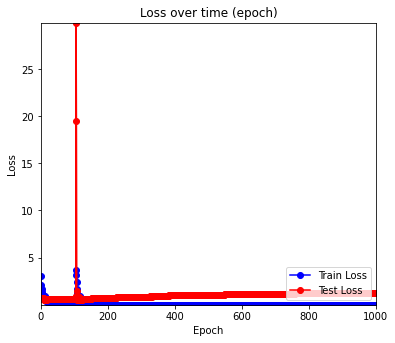


---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 637
False Positive : 145
False Negative : 97
True Negative : 271

Class positive Evaluation
- Precision : 81.458 %
- Recall : 86.785 %
- F1 : 0.84037

Class negative Evaluation
- Precision : 73.641 %
- Recall : 65.144 %
- F1 : 0.69133

Combined Evaluation
- Accuracy : 78.957 %
- Precision : 77.55 %
- Recall : 75.964 %
- F1 : 0.76749
- Average Confidence : 72.65 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet18_MLP_DistilBERT_NLI_Mean, 78.957, 77.55, 75.964, 0.76749, 81.458, 86.785, 0.84037, 73.641, 65.144, 0.69133, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 673
False Positive : 152
False Negative : 100
True Negative : 229

Class positive Evaluation
- Precision : 81.576 %
- Recall : 87.063 %
- F1 : 0.8423

Class negative Evaluation
- Precision : 69.605 %
- Recall : 60.105 %
- F1 : 0.64507

Combined Evaluation
- Accurac

In [13]:
model_name = f"Phemernr1_ResNet18_MLP_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(ResNet18(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16) #, device="cpu")
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

In [14]:
model_name = f"Phemernr1_ResNet10_CNN_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(CNNResNet10(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

Multiclass Classification Phemernr1_ResNet10_CNN_DistilBERT_NLI_Mean

---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 657
False Positive : 93
False Negative : 77
True Negative : 323

Class positive Evaluation
- Precision : 87.6 %
- Recall : 89.51 %
- F1 : 0.88544

Class negative Evaluation
- Precision : 80.75 %
- Recall : 77.644 %
- F1 : 0.79167

Combined Evaluation
- Accuracy : 85.217 %
- Precision : 84.175 %
- Recall : 83.577 %
- F1 : 0.83875
- Average Confidence : 73.29 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet10_CNN_DistilBERT_NLI_Mean, 85.217, 84.175, 83.577, 0.83875, 87.6, 89.51, 0.88544, 80.75, 77.644, 0.79167, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 698
False Positive : 94
False Negative : 75
True Negative : 287

Class positive Evaluation
- Precision : 88.131 %
- Recall : 90.298 %
- F1 : 0.89201

Class negative Evaluation
- Precision : 79.282 %
- Re

In [15]:
model_name = f"Phemernr1_ResNet18_CNN_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(CNNResNet18(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

Multiclass Classification Phemernr1_ResNet18_CNN_DistilBERT_NLI_Mean

---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 673
False Positive : 127
False Negative : 61
True Negative : 289

Class positive Evaluation
- Precision : 84.125 %
- Recall : 91.689 %
- F1 : 0.87744

Class negative Evaluation
- Precision : 82.571 %
- Recall : 69.471 %
- F1 : 0.75457

Combined Evaluation
- Accuracy : 83.652 %
- Precision : 83.348 %
- Recall : 80.58 %
- F1 : 0.81941
- Average Confidence : 88.57 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet18_CNN_DistilBERT_NLI_Mean, 83.652, 83.348, 80.58, 0.81941, 84.125, 91.689, 0.87744, 82.571, 69.471, 0.75457, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 711
False Positive : 106
False Negative : 62
True Negative : 275

Class positive Evaluation
- Precision : 87.026 %
- Recall : 91.979 %
- F1 : 0.89434

Class negative Evaluation
- Precision : 81.60